In [ ]:
# import zipfile as zf
# files = zf.ZipFile("images.zip", 'r')
# files.extractall('C:\\Users\\User\\Mask_classification/images')
# files.close()
# df.to_csv('mask_train.csv')

데이터 증강 -> 불균형을 해소하는데 적용을 하고 -> over sampling -> center crop, rotation, noise, gan

            -> 균형 잡힌 cutmix, cutsdfsdf, fmix

In [2]:
ROOT_DIR = './images/images'

In [3]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
df

,file,gender,age,mask,class,age_group
0,000001_female_Asian_45/incorrect_mask.jpg,female,45,incorrect,10.0,middle
1,000001_female_Asian_45/mask1.jpg,female,45,mask,4.0,middle
2,000001_female_Asian_45/mask2.jpg,female,45,mask,4.0,middle
3,000001_female_Asian_45/mask3.jpg,female,45,mask,4.0,middle
4,000001_female_Asian_45/mask4.jpg,female,45,mask,4.0,middle
...,...,...,...,...,...,...
18895,006959_male_Asian_19/mask2.jpg,male,19,mask,0.0,young
18896,006959_male_Asian_19/mask3.jpg,male,19,mask,0.0,young
18897,006959_male_Asian_19/mask4.jpg,male,19,mask,0.0,young
18898,006959_male_Asian_19/mask5.jpg,male,19,mask,0.0,young


In [11]:
df.to_csv("mask_draft_file")

In [22]:
new_df = df[['gender', 'age_group', 'mask', 'class']].groupby(by=['gender', 'age_group', 'mask', 'class']).count()

In [32]:
new_df.sort_values(by='class', inplace=True)

In [24]:
eval_df = pd.read_csv("submission.csv")

In [25]:
eval_df.head(10)

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,13
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,1
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,13
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,13
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,13
5,7953c2e6e983bad91b89a0e4ad7eb69e6e43e56b.jpg,1
6,1903db7dcc1262d0441677afa422e6a8371e5b37.jpg,7
7,441419a874f4d031cd576850b68539ca7d35bedf.jpg,3
8,388856cd1ef99b1918273a827a75f2aff2478321.jpg,4
9,795ba8ccc769a3f9da6a897f75df6706b729345b.jpg,3


In [35]:
x = eval_df['ans'].value_counts().sort_index()

In [38]:
x

0      104
1     4821
2       45
3     2311
4     1176
5     1004
6       55
7      606
8       29
9      406
10     140
11     110
12      43
13    1001
14       4
15     328
16     366
17      51
Name: ans, dtype: int64

In [36]:
new_df['detection_num'] = x

In [40]:
new_df

detection_num
gender age_group mask      class               
male   young     mask      0.0              NaN
       middle    mask      1.0              NaN
       old       mask      2.0              NaN
female young     mask      3.0              NaN
       middle    mask      4.0              NaN
       old       mask      5.0              NaN
male   young     incorrect 6.0              NaN
       middle    incorrect 7.0              NaN
       old       incorrect 8.0              NaN
female young     incorrect 9.0              NaN
       middle    incorrect 10.0             NaN
       old       incorrect 11.0             NaN
male   young     normal    12.0             NaN
       middle    normal    13.0             NaN
       old       normal    14.0             NaN
female young     normal    15.0             NaN
       middle    normal    16.0             NaN
       old       normal    17.0             NaN

In [333]:
plt.style.use('seaborn-pastel')

### 카테고리별 데이터 분포 확인하기

1. 데이터가 불균형하다
2. 남성 데이터를 늘려주기 전에 먼저 여성 데이터의 Mask, Age데이터의 불균형 부터 해소하자
3. 그 후 늘어난 여성 데이터 수에 맞춰 남성 데이터도 늘려주자

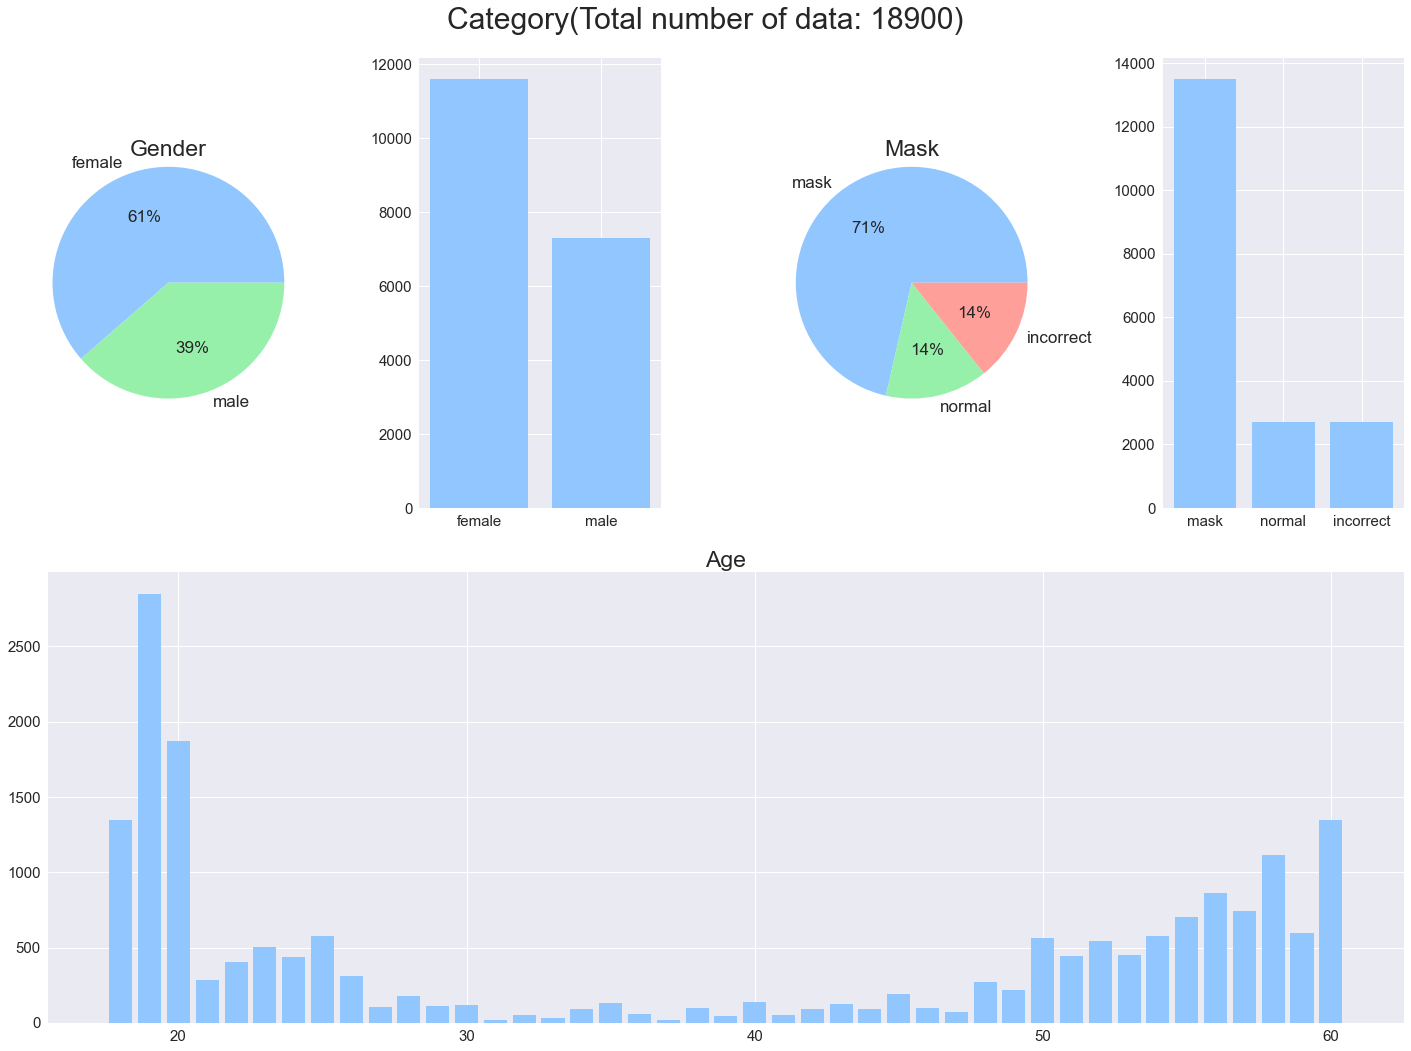

In [435]:
fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(241)
ax2 = fig.add_subplot(242)
ax3 = fig.add_subplot(243)
ax4 = fig.add_subplot(244)
ax5 = fig.add_subplot(212)


fig.suptitle("Category(Total number of data: 18900)", fontsize=30)
ax1.pie(df['gender'].value_counts(), labels=['female', 'male'], textprops={'fontsize': 17}, autopct='%.0f%%', radius=1.2)
ax1.tick_params(labelsize=15)
ax1.set_title("Gender", fontsize=23)


ax3.pie(df['mask'].value_counts(), labels=['mask', 'normal', 'incorrect'], textprops={'fontsize': 17}, autopct='%.0f%%', radius=1.2)
ax3.tick_params(labelsize=15)
ax3.set_title("Mask", fontsize=23)


ax5.bar(np.arange(18, 61), df['age'].value_counts().sort_index())
ax5.set_title("Age", fontsize=23)
ax5.tick_params(labelsize=15)

ax2.bar(['female', 'male'], df['gender'].value_counts())
ax2.tick_params(labelsize=15)

ax4.bar(['mask', 'normal', 'incorrect'], df['mask'].value_counts())
ax4.tick_params(labelsize=15)

fig.tight_layout()

### 여성 데이터의 카테고리 분포 확인하기

Text(0.5, 1.0, 'Age of Female')

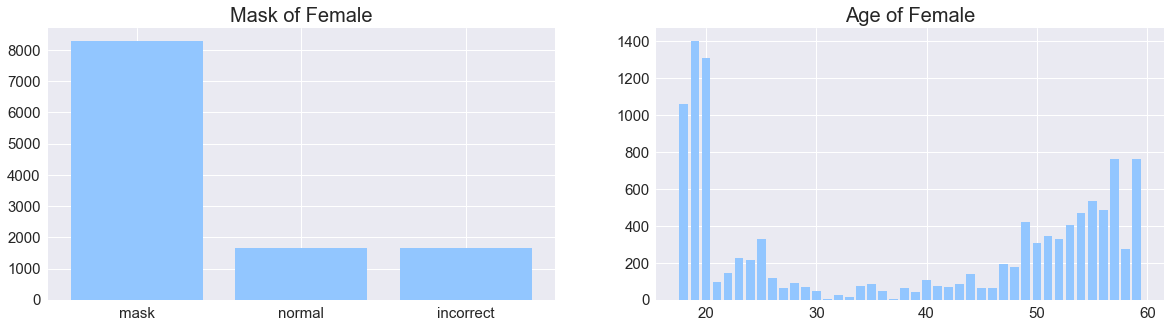

In [402]:
fig, ax = plt.subplots(figsize=(20, 5), nrows=1, ncols=2)

ax[0].bar(['mask', 'normal', 'incorrect'], df[df['gender']=='female']['mask'].value_counts())
ax[0].tick_params(labelsize=15)
ax[0].set_title("Mask of Female", fontsize=20)

ax[1].bar(np.arange(18, 60), df[df['gender']=='female']['age'].value_counts().sort_index())
ax[1].tick_params(labelsize=15)
ax[1].set_title("Age of Female", fontsize=20)

1. 성별에 관계 없이 마스크와 나이의 분포는 비슷한 것 같다
2. 마스크를 쓴 사진이 약 70% 정도를 차지하는데 mask별 나이의 분포까지 확인해보면 어떤 데이터를 늘려줘야할지 알 수 있을 것 같다

### 여성의 마스크별 나이데이터 분포

In [382]:
df_female_mask_age = df[df['gender']=='female'][['mask', 'age','class']].groupby(['mask', 'age']).count()

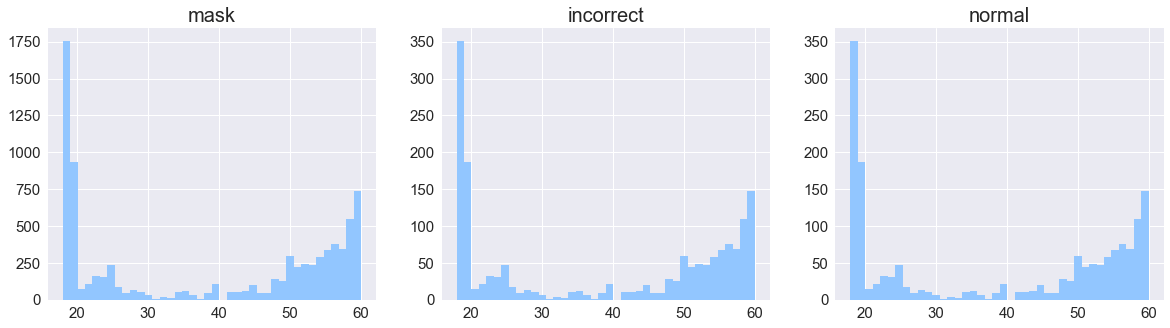

In [389]:
fig, ax = plt.subplots(figsize=(20, 5), nrows=1, ncols=3)
ax[0].hist(df[(df['gender']=='female')& (df['mask']=='mask')][['age']], bins=40)
ax[0].set_title("mask",fontsize=20)
ax[0].tick_params(labelsize=15)
ax[1].hist(df[(df['gender']=='female')& (df['mask']=='incorrect')][['age']], bins=40)
ax[1].set_title("incorrect",fontsize=20)
ax[1].tick_params(labelsize=15)
ax[2].hist(df[(df['gender']=='female')& (df['mask']=='normal')][['age']], bins=40)
ax[2].set_title("normal",fontsize=20)
ax[2].tick_params(labelsize=15)

### 남성의 마스크, 나이 분포

Text(0.5, 1.0, 'Age of Male')

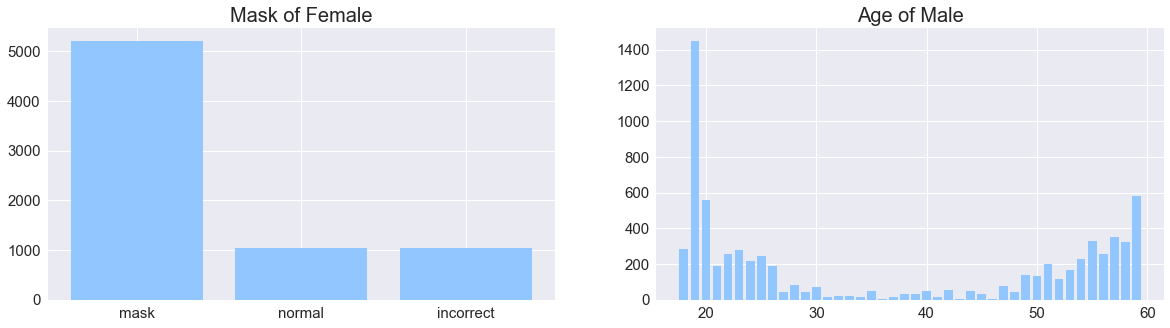

In [391]:
fig, ax = plt.subplots(figsize=(20, 5), nrows=1, ncols=2)

ax[0].bar(['mask', 'normal', 'incorrect'], df[df['gender']=='male']['mask'].value_counts())
ax[0].tick_params(labelsize=15)
ax[0].set_title("Mask of Female", fontsize=20)

ax[1].bar(np.arange(18, 60), df[df['gender']=='male']['age'].value_counts().sort_index())
ax[1].tick_params(labelsize=15)
ax[1].set_title("Age of Male", fontsize=20)

### 남성의 마스크별 나이 분포

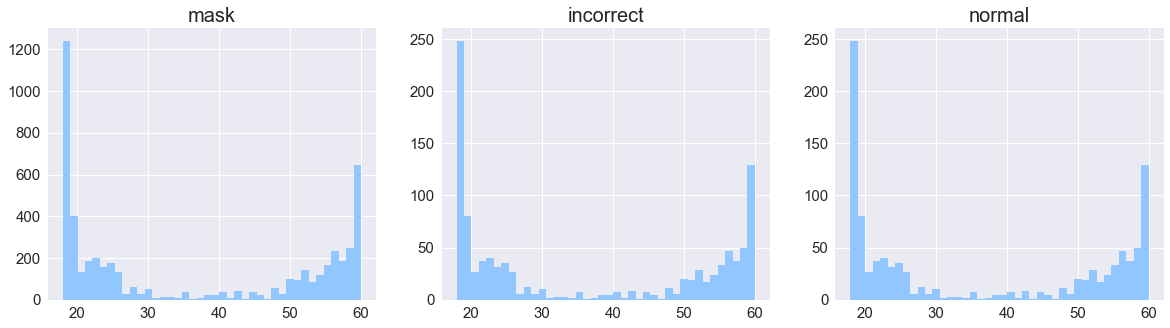

In [390]:
fig, ax = plt.subplots(figsize=(20, 5), nrows=1, ncols=3)
ax[0].hist(df[(df['gender']=='male')& (df['mask']=='mask')][['age']], bins=40)
ax[0].set_title("mask",fontsize=20)
ax[0].tick_params(labelsize=15)
ax[1].hist(df[(df['gender']=='male')& (df['mask']=='incorrect')][['age']], bins=40)
ax[1].set_title("incorrect",fontsize=20)
ax[1].tick_params(labelsize=15)
ax[2].hist(df[(df['gender']=='male')& (df['mask']=='normal')][['age']], bins=40)
ax[2].set_title("normal",fontsize=20)
ax[2].tick_params(labelsize=15)

### 클래스별 분포

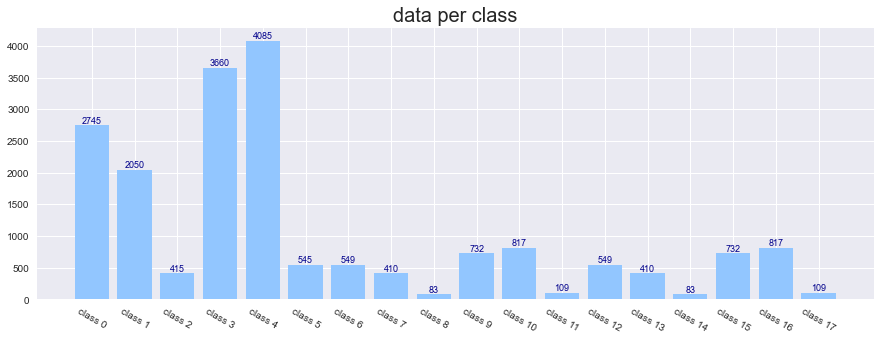

In [427]:
fig, ax = plt.subplots(figsize=(15, 5))
y = df['class'].value_counts().sort_index()
data_labels = ['class ' + str(i) for i in range(18)]

ax.bar(np.arange(18), y)
ax.set_xticks(np.arange(18))
ax.set_xticklabels(data_labels, rotation=-30)
ax.set_title("data per class", fontsize=20)

for i, v in enumerate(range(18)):
    plt.text(v, y[i], y[i],                 # 좌표 (x축 = v, y축 = y[0]..y[1], 표시 = y[0]..y[1])
             fontsize = 9, 
             color='darkblue',
             horizontalalignment='center',  # horizontalalignment (left, center, right)
             verticalalignment='bottom')    # verticalalignment (top, center, bottom)

### 허무한 결론

1. class별 데이터의 수를 맞추자
2. 데이터를 판다스의 Selection과 Filtering을 통해 class별 csv를 만들자
3. class별 데이터를 Augmentation하자

oversampling -> rotation, noise gan

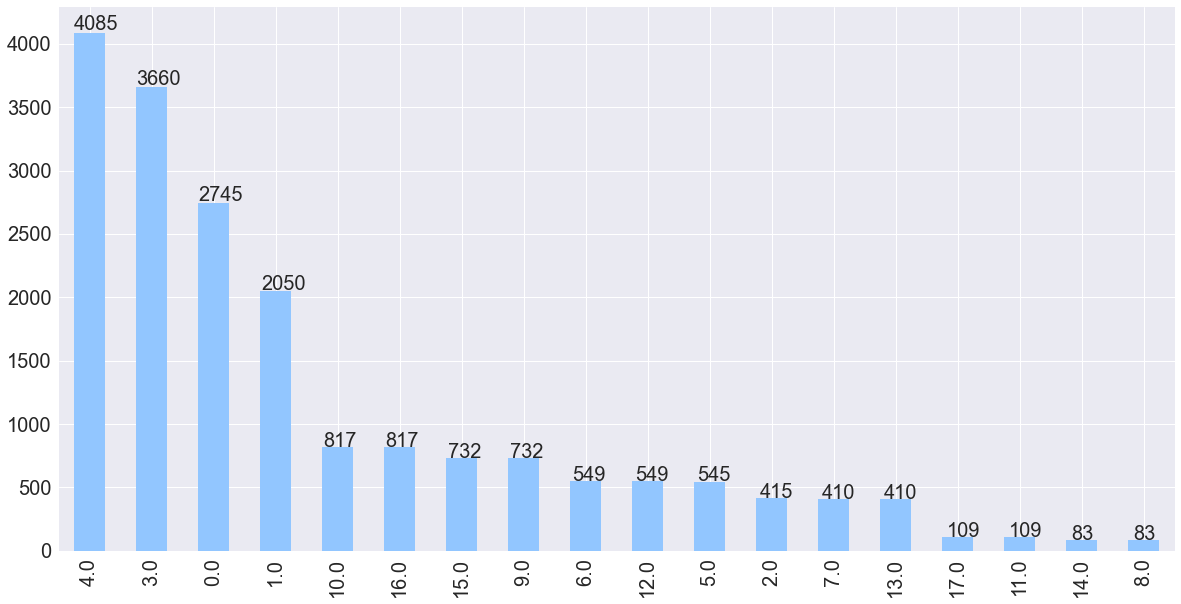

In [486]:
ax = df['class'].value_counts().plot(kind='bar', figsize=(20, 10), fontsize=20)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

In [512]:
df[df['class'] == 0][['file', 'class']].to_csv('mask_class_0.csv')

In [1]:
df.head(10)

NameError: name 'df' is not defined